# Relax Take Home Challenge

# Summary:

The five factors that I found to be the most important to determining user adoption were:

1. User opted in to emailing List
2. User enable for Marketing Drip
3. User account originated from a Personal Project invitation
4. The number of invitations user sent
5. The total number of users at respective organization

In EDA, it was found that adopted users were more likely to have opted into and be receiving marketing material. Adopted users appeared to be less likely to have created accounts from personal project invites.  Adopted users also appeared to be more likely to send invitations. Adopted users appeared to be more likely from smaller organzations as well.

#### Modeling
The top five factors above were determing by running the data through a Gradient Boosting Classifiaction model using the Synthetic Minority Over-sampling Technique(SMOTE).  SMOTE was used as Adopted users were under represented in this dataset.  The basic features used in predicting an adopted user were as follows:

1. Origin of account creation
2. Whether user opted into marketing emails
3. Whether user was enabled for marketing drip
4. The total number of users at observation user's organization
5. The total invitations user has sent
6. The user's email handle

The final model had an overall accuracy of 73% and a precision of 19% and a recall of 29% on Adopted user cases.  Meaning  19% of the model's adopted user predictions were accurate and the model was able to accurately identify 29% of adopted users. 


# Coding:

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')
user_info = pd.read_csv('takehome_users.csv', encoding = 'latin-1')

In [169]:
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
user_engagement['date'] =  user_engagement['time_stamp'].dt.date

user_count = len(user_engagement['user_id'].unique())
login_count =len(user_engagement)

print('The dataset is comprised of {} logins by {} users'. format(login_count, user_count))
print('The first entry is from: {}'.format(user_engagement['time_stamp'].min()))
print('The last entry is from: {}'.format(user_engagement['time_stamp'].max()))



The dataset is comprised of 207917 logins by 8823 users
The first entry is from: 2012-05-31 08:20:06
The last entry is from: 2014-06-06 14:58:50


## Data Wrangling

In [170]:


counts = user_engagement['user_id'].value_counts()
min_thres_users = list(counts[counts>=3].index)

users = list(user_engagement['user_id'].unique())
user_consec_logins = dict.fromkeys(users,0)

for user in min_thres_users:
    
    login_dates_set = set(user_engagement[user_engagement['user_id']== user]['date']) ##Set of Logins by user
    
    
    for date in user_engagement[user_engagement['user_id']== user]['date']:
        
        login_7day_set = set([date + pd.Timedelta(value = x, unit ='D') for x in range(7)]) # Set of 7 days from each login
        
        intersection = login_7day_set.intersection(login_dates_set)
        
        if (len(list(intersection)))>= 3:
            user_consec_logins[user] = 1
            break

            
adopted_user = pd.DataFrame({'user_id': list(user_consec_logins.keys()),
                             'adopted': list(user_consec_logins.values())})

#adopted_user['adopted']= [True if x == 1 else False for x in adopted_user['adopted']]

merged_user_info = user_info.merge(adopted_user, how = 'left',left_on = 'object_id', right_on = 'user_id')

merged_user_info['adopted'].value_counts()    


0.0    7221
1.0    1602
Name: adopted, dtype: int64

In [171]:
merged_user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  user_id                     8823 non-null   float64
 11  adopted                     8823 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.2+ MB


In [172]:
merged_user_info['adopted'].fillna(0, inplace =True)

In [173]:
merged_user_info['creation_time'] = pd.to_datetime(merged_user_info['creation_time'])
merged_user_info['last_session_creation_time'] = pd.to_datetime(merged_user_info['last_session_creation_time'], unit = 's')

In [174]:
org_counts = (merged_user_info['org_id'].value_counts().rename_axis('orgs').to_frame('org_user_counts'))

merged_user_info = merged_user_info.merge(org_counts, how = 'left', left_on = 'org_id', right_index = True)

In [175]:
invite_count = merged_user_info['invited_by_user_id'].value_counts().rename_axis('user_id').to_frame('invitations_sent')

merged_user_info = merged_user_info.merge(invite_count, how = 'left' , left_on = 'object_id', right_on = 'user_id')

merged_user_info['invitations_sent'].fillna(0, inplace = True)

merged_user_info.drop('invited_by_user_id', axis = 1, inplace = True)

In [176]:
merged_user_info['email_handle'] = [x.split('@')[1] for x in merged_user_info['email'] ]

handle_counts = merged_user_info['email_handle'].value_counts()
most_common_handles = list(handle_counts[handle_counts>1000].index)

merged_user_info['email_handle'] = [x if x in most_common_handles else 'Other' for x in merged_user_info['email_handle']]

merged_user_info.drop('email', axis = 1, inplace = True)

In [177]:
merged_user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   user_id                     8823 non-null   float64       
 9   adopted                     12000 non-null  float64       
 10  org_user_counts             12000 non-null  int64         
 11  invitations_sent            12000 non-null  float64   

In [178]:
merged_user_info.drop('user_id', axis = 1, inplace = True)

## EDA

In [179]:
print('This dataset contains {} unique Users'.format(len(merged_user_info['object_id'].unique())))
print('Users who work with {} unique organizations'.format(len(merged_user_info['org_id'].unique())))

This dataset contains 12000 unique Users
Users who work with 417 unique organizations


In [180]:
merged_user_info.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,org_user_counts,invitations_sent
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,0.133500,55.108500,0.534750
std,3464.24595,0.432742,0.356432,124.056723,0.340128,64.023959,1.350473
min,1.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,0.000000,21.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,0.000000,29.000000,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,0.000000,55.000000,0.000000
max,12000.00000,1.000000,1.000000,416.000000,1.000000,319.000000,13.000000


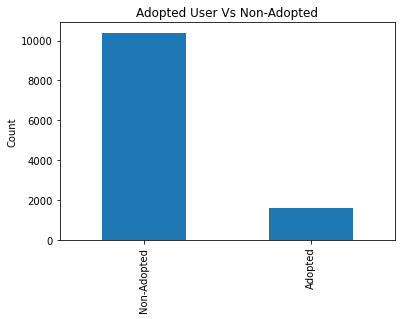

In [181]:
merged_user_info['adopted'].value_counts().plot(kind = 'bar')
plt.xticks([0,1],['Non-Adopted', 'Adopted'])
plt.ylabel('Count')
plt.title('Adopted User Vs Non-Adopted')
plt.show()


In [182]:
def EDA_cat(df,g1,g2):

    source_count = df.groupby(g1)[g2].value_counts(normalize = True).unstack().transpose()

    source_count.plot(kind='bar', figsize=(7, 5), xlabel=g2, ylabel='Percent', rot=45)

    plt.legend(title=g1, bbox_to_anchor=(1, 1), loc='upper left')
    
    plt.title('{} by {}'.format(g2,g1))


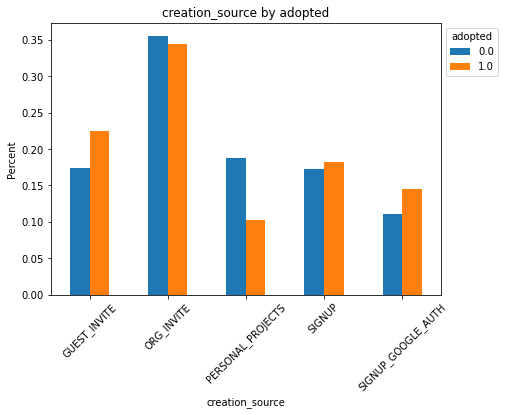

In [183]:
EDA_cat(merged_user_info, 'adopted','creation_source')


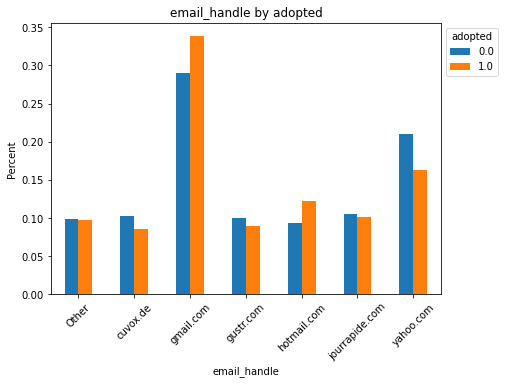

In [184]:
EDA_cat(merged_user_info, 'adopted','email_handle')

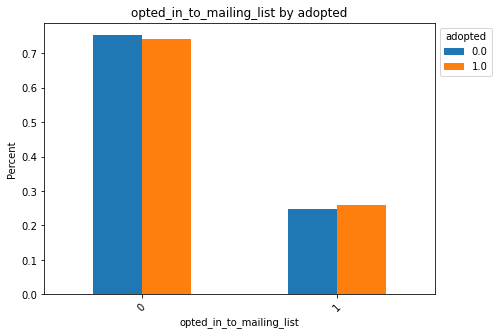

In [185]:
EDA_cat(merged_user_info, 'adopted','opted_in_to_mailing_list')

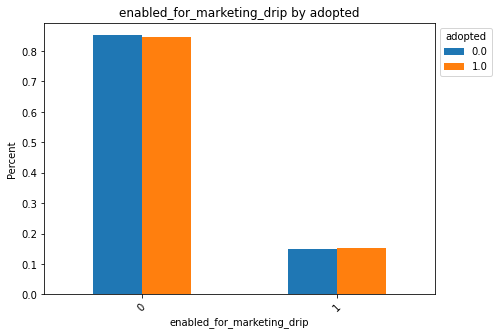

In [186]:
EDA_cat(merged_user_info, 'adopted','enabled_for_marketing_drip')

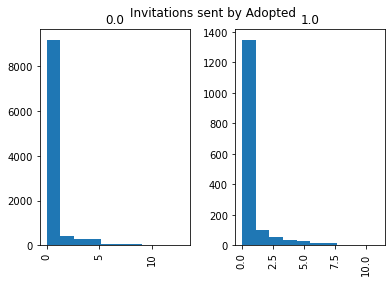

In [187]:
merged_user_info['invitations_sent'].hist(by=merged_user_info['adopted'],bins =10)

plt.suptitle('Invitations sent by Adopted')

plt.show()

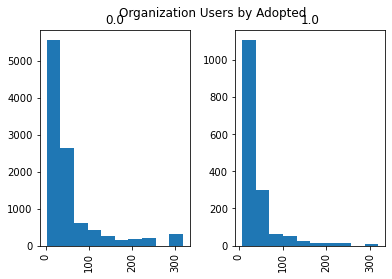

In [188]:
merged_user_info['org_user_counts'].hist(by=merged_user_info['adopted'],bins =10)

plt.suptitle('Organization Users by Adopted')

plt.show()

## Preprocessing

In [189]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

In [190]:
target = merged_user_info['adopted']
features = merged_user_info.drop(['object_id', 
                                  'creation_time',
                                  'name', 
                                  'last_session_creation_time',
                                  'org_id',
                                  'adopted'],
                                  axis = 1)

In [191]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_user_counts             12000 non-null  int64  
 4   invitations_sent            12000 non-null  float64
 5   email_handle                12000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 976.2+ KB


In [192]:
features = pd.get_dummies(features)

cols = ['org_user_counts', 'invitations_sent'] 

col_trans = ColumnTransformer([('scaler',StandardScaler(), cols)],remainder = 'passthrough')

X =col_trans.fit_transform(features)

y = target

In [193]:
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                    test_size=0.4, 
                                                    random_state=343)

#### SMOTE Resampling

In [194]:
from imblearn.over_sampling import SMOTE

In [195]:
smote = SMOTE()

X_smt, y_smt = smote.fit_resample(X_train, y_train)



In [196]:
print('The original training set has {} observation with {} of the adopted class'.format(len(X_train),y_train.sum()))
print('The SMOTE training set has {} observation with {} of the adopted class'.format(len(X_smt),y_smt.sum()))


The original training set has 7200 observation with 937.0 of the adopted class
The SMOTE training set has 12526 observation with 6263.0 of the adopted class


## Modeling

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [198]:
def model_eval(model, X_train, y_train, X_test, y_test):
    print()
    print(model)
    print()
    model = model
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()


LogisticRegression(random_state=343)

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93      4135
         1.0       0.00      0.00      0.00       665

    accuracy                           0.86      4800
   macro avg       0.43      0.50      0.46      4800
weighted avg       0.74      0.86      0.80      4800



C:\Users\kyu_k\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kyu_k\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kyu_k\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


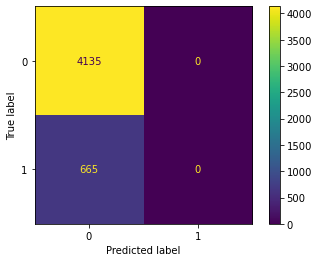


RandomForestClassifier(random_state=343)

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      4135
         1.0       0.15      0.07      0.09       665

    accuracy                           0.82      4800
   macro avg       0.50      0.50      0.50      4800
weighted avg       0.76      0.82      0.79      4800



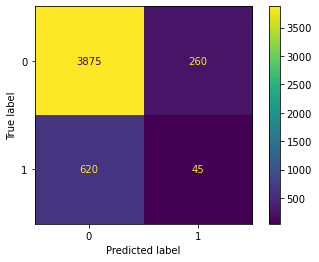


GradientBoostingClassifier(random_state=343)

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      4135
         1.0       0.00      0.00      0.00       665

    accuracy                           0.86      4800
   macro avg       0.43      0.50      0.46      4800
weighted avg       0.74      0.86      0.80      4800



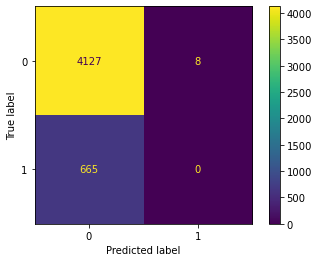

In [199]:
models= [LogisticRegression(random_state = 343),
        RandomForestClassifier(random_state = 343),
        GradientBoostingClassifier(random_state = 343)]

for model in models:
        
    model_eval(model,
           X_train,
           y_train,
           X_test,
           y_test)


LogisticRegression(random_state=343)

              precision    recall  f1-score   support

         0.0       0.90      0.46      0.61      4135
         1.0       0.17      0.67      0.27       665

    accuracy                           0.49      4800
   macro avg       0.53      0.57      0.44      4800
weighted avg       0.80      0.49      0.56      4800



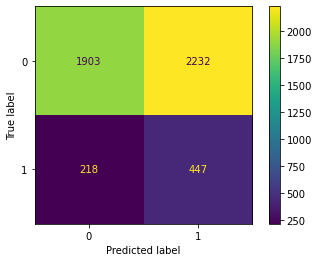


RandomForestClassifier(random_state=343)

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4135
         1.0       0.14      0.16      0.15       665

    accuracy                           0.75      4800
   macro avg       0.50      0.50      0.50      4800
weighted avg       0.76      0.75      0.75      4800



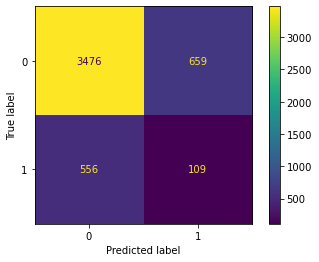


GradientBoostingClassifier(random_state=343)

              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85      4135
         1.0       0.19      0.25      0.22       665

    accuracy                           0.75      4800
   macro avg       0.53      0.54      0.53      4800
weighted avg       0.78      0.75      0.76      4800



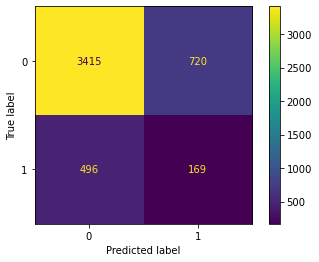

In [200]:
models= [LogisticRegression(random_state = 343),
        RandomForestClassifier(random_state = 343),
        GradientBoostingClassifier(random_state = 343)]

for model in models:
        
    model_eval(model,
            X_smt,
           y_smt,
           X_test,
           y_test)

### Gradient Boost

In [201]:
from sklearn.model_selection import RandomizedSearchCV

In [202]:

n_estimators = [100, 200, 300, 400]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8] 
min_samples_split = [2, 4, 6, 10]
learn_rates = [0.02, 0.05]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'learning_rate': learn_rates
    }

GB = GradientBoostingClassifier(random_state = 343)
RandGB = RandomizedSearchCV(GB, hyperparameter_grid, random_state = 343, scoring = 'f1_weighted')
RandGB.fit(X_smt,y_smt)
RandGB.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 10,
 'learning_rate': 0.05}

In [203]:
def model_eval2(model, X_train, y_train, X_test, y_test):
    print()
    print(model)
    print()
    model = model
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    return(model)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=343)

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85      4135
         1.0       0.19      0.26      0.22       665

    accuracy                           0.74      4800
   macro avg       0.53      0.54      0.53      4800
weighted avg       0.78      0.74      0.76      4800



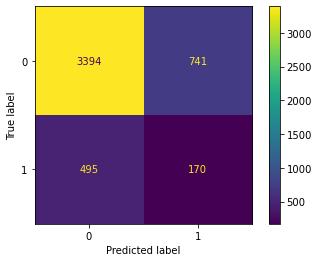

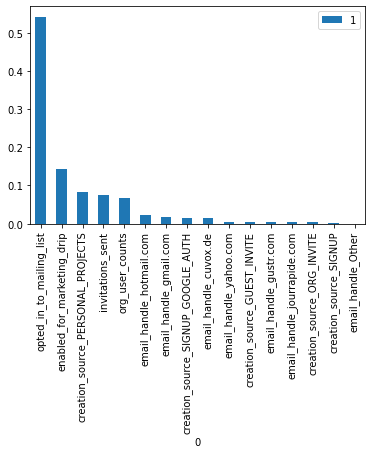

In [204]:


GB2 = model_eval2(GradientBoostingClassifier(n_estimators = 200 ,
                                       min_samples_split= 2,
                                       learning_rate =.05,
                                       random_state = 343), 
                                        X_smt,
                                        y_smt,
                                        X_test,
                                        y_test)

importances = pd.DataFrame(zip(features.columns,GB2.feature_importances_))
importances.sort_values(by = 1, ascending =False, inplace =True)
importances.plot(kind = 'bar', x =0 , y =1)
plt.show()

In [205]:
importances

,0,1
0,opted_in_to_mailing_list,0.541995
1,enabled_for_marketing_drip,0.143501
6,creation_source_PERSONAL_PROJECTS,0.082347
3,invitations_sent,0.074227
2,org_user_counts,0.067865
13,email_handle_hotmail.com,0.021437
11,email_handle_gmail.com,0.016842
8,creation_source_SIGNUP_GOOGLE_AUTH,0.013600
10,email_handle_cuvox.de,0.013587
15,email_handle_yahoo.com,0.005477
